## Simulated and Measured GIC Comparison

In [352]:
import os
import warnings
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

import scipy.signal
from scipy.ndimage import gaussian_filter1d
from scipy import signal

# Rebuild the font cache
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
warnings.simplefilter("ignore", UserWarning)  # Ignores only UserWarnings

In [2]:
data_loc = Path("2024-AGU-data")
nerc_gic = data_loc / 'nerc' /'gic'

<Axes: >

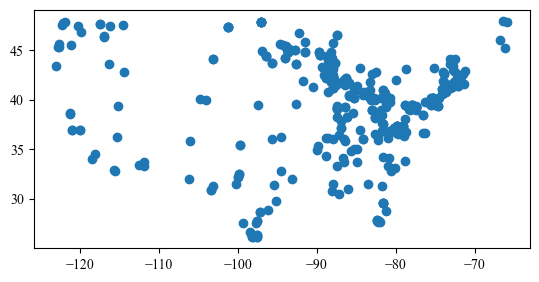

In [295]:
csv_files = list(nerc_gic.glob('*.csv'))

gic_monitors_df = pd.read_csv(csv_files[-1])
gic_monitors_df.rename(columns={" Latitude": "latitude", " Longitude": "longitude"}, inplace=True)
# Check and adjust longitude values if needed
gic_monitors_df["longitude"] = gic_monitors_df["longitude"].apply(
    lambda x: -x if x > 0 and x > 60 else x
)
geometry = [Point(xy) for xy in zip(gic_monitors_df["longitude"], gic_monitors_df["latitude"])]
gdf_monitors = gpd.GeoDataFrame(gic_monitors_df, geometry=geometry, crs="EPSG:4326")

# Plot to verify
gdf_monitors.plot()

In [296]:
# Read the simulation file
gdf_mean_df = pd.read_csv(data_loc / 'gic_mean_df_1.csv')

# Make lat longitude a column
geometry = [Point(xy) for xy in zip(gdf_mean_df["longitude"], gdf_mean_df["latitude"])]
gdf_mean_sim = gpd.GeoDataFrame(gdf_mean_df, geometry=geometry, crs="EPSG:4326")

In [297]:
# Define degree-based threshold
LAT_LON_THRESHOLD = 0.02

# Find matching points
matching_sites = []

for idx_sim, sim_row in gdf_mean_sim.iterrows():
    # Find monitors within lat/lon threshold
    nearby_monitors = gdf_monitors[
        (abs(gdf_monitors["latitude"] - np.round(sim_row["latitude"], 1)) <= LAT_LON_THRESHOLD)
        & (abs(gdf_monitors["longitude"] - np.round(sim_row["longitude"], 1)) <= LAT_LON_THRESHOLD)
    ]

    if not nearby_monitors.empty:
        for _, monitor_row in nearby_monitors.iterrows():
            matching_sites.append(
                {
                    "substation": sim_row["sub_id"],
                    "sub_lat": sim_row["latitude"],
                    "sub_lon": sim_row["longitude"],
                    "monitor_name": monitor_row["Device ID"],
                    "monitor_lat": monitor_row["latitude"],
                    "monitor_lon": monitor_row["longitude"],
                }
            )

# Create DataFrame of matches
matches_df = pd.DataFrame(matching_sites)

# Drop duplicates
matches_df.drop_duplicates(subset=["substation", "monitor_name"], inplace=True)
matches_df

,substation,sub_lat,sub_lon,monitor_name,monitor_lat,monitor_lon
0,9094967,45.542823,-94.274360,10348,45.5,-94.3
4,10390117,39.022102,-83.009678,10483,39.0,-83.0
5,10390117,39.022102,-83.009678,10484,39.0,-83.0
6,10390117,39.022102,-83.009678,10485,39.0,-83.0
16,10390118,40.718566,-81.416346,10563,40.7,-81.4
...,...,...,...,...,...,...
1372,1072135234,40.100424,-104.772866,10637,40.1,-104.8
1376,1111901665,35.377151,-99.719740,10463,35.4,-99.7
1377,1111901665,35.377151,-99.719740,10464,35.4,-99.7
1384,1194159493,41.892532,-86.201415,10511,41.9,-86.2


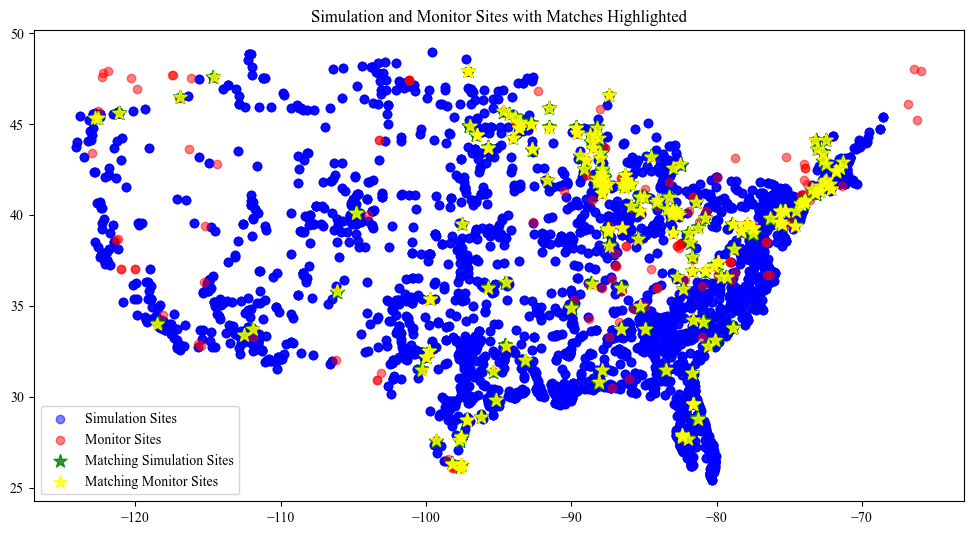

In [299]:
# Visualize the matches
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all simulation points
gdf_mean_sim.plot(ax=ax, color="blue", alpha=0.5, label="Simulation Sites")

# Plot all monitor points
gdf_monitors.plot(ax=ax, color="red", alpha=0.5, label="Monitor Sites")

# Highlight matching points
if len(matches_df) > 0:
    matching_sim_sites = gdf_mean_sim[
        gdf_mean_sim["sub_id"].isin(matches_df["substation"])
    ]
    matching_monitor_sites = gdf_monitors[
        gdf_monitors["Device ID"].isin(matches_df["monitor_name"])
    ]

    matching_sim_sites.plot(
        ax=ax,
        color="green",
        alpha=0.8,
        marker="*",
        markersize=100,
        label="Matching Simulation Sites",
    )
    matching_monitor_sites.plot(
        ax=ax,
        color="yellow",
        alpha=0.8,
        marker="*",
        markersize=100,
        label="Matching Monitor Sites",
    )

plt.title("Simulation and Monitor Sites with Matches Highlighted")
plt.legend()
plt.show()

In [300]:
if os.path.exists(data_loc / "nerc_gic.nc"):
    ds = xr.open_dataset(data_loc / "nerc_gic.nc")

else:
    device_data = {}
    timestamps_set = set()

    # Step 1: Read files and store data per device
    for file in nerc_files:
        df = pd.read_csv(file)
        df["SampleDateTime"] = pd.to_datetime(
            df["SampleDateTime"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
        )

        for device_id, group in df.groupby("GICDeviceID"):
            if device_id not in device_data:
                device_data[device_id] = {}

            timestamps_set.update(group["SampleDateTime"])
            device_data[device_id].update(
                dict(zip(group["SampleDateTime"], group["GICMeasured"]))
            )

    # Step 2: Create a uniform time index
    timestamps = sorted(timestamps_set)

    # Step 3: Convert data to a 2D array (time x device), filling missing values with NaN
    device_ids = sorted(device_data.keys())
    data_array = np.full((len(timestamps), len(device_ids)), np.nan)

    for j, device_id in enumerate(device_ids):
        for i, timestamp in enumerate(timestamps):
            if timestamp in device_data[device_id]:
                data_array[i, j] = device_data[device_id][timestamp]

    # Step 4: Create an Xarray Dataset
    ds = xr.Dataset(
        data_vars={"gic": (["time", "device"], data_array)},
        coords={"time": timestamps, "device": device_ids},
    )

    ## Add metadata
    # Step 5: Add metadata from `gic_monitors_df`
    metadata_cols = [
        "latitude",
        "longitude",
        " Installation Type",
        " Connection",
        " Minimum Value in Measurement Range",
    ]

    gic_monitors_dict = gic_monitors_df.set_index("Device ID").to_dict()

    for col in metadata_cols:
        ds = ds.assign_coords(
            {
                col.lower().replace(" ", "_"): (
                    "device",
                    [gic_monitors_dict[col].get(d, np.nan) for d in device_ids],
                )
            }
        )

    # Save the xarray dataset to a NetCDF file
    ds.to_netcdf(data_loc / "nerc_gic.nc")

In [301]:
# Read the magnetic data
nerc_mag_folder = data_loc / 'nerc' / 'mag'

# glob files if start with 2024*.csv
mag_files = list(nerc_mag_folder.glob('2024*.csv'))

# Read magnetic data locs
mag_locs_df = pd.read_csv(nerc_mag_folder / "magnetometers.csv")

# Rename columns removing white spaces
mag_locs_df.rename(
    columns={
        "Device ID": "device_id",
        " Latitude": "latitude",
        " Longitude": "longitude",
        " Orientation": "orientation",
    },
    inplace=True,
)

# Filtere only geographic orientation
# Filter out only geographic coordinates
mag_locs_df = mag_locs_df[mag_locs_df["orientation"] == "1 - Geographic"].copy()

# Since in US, longitude is negative, we need to adjust
mag_locs_df["longitude"] = mag_locs_df["longitude"].apply(
    lambda x: -x if x > 0 and x > 60 else x
)

# Some orientations are geographic while others are geomagnetic
df_list = [pd.read_csv(f) for f in mag_files]
mag_df = pd.concat(df_list, ignore_index=True)

# Rename columns for consistency
mag_df.rename(
    columns={
        "MagnetometerDeviceID": "device_id",
        "SampleDateTime": "time",
        "GeoBfieldMeasureNorth": "B_North",
        "GeoBfieldMeasureEast": "B_East",
        "GeoBfieldMeasureVertical": "B_Vertical",
    },
    inplace=True,
)

In [302]:
# Convert time column to datetime format
mag_df["time"] = pd.to_datetime(mag_df["time"], format="%m/%d/%Y %I:%M:%S %p")

# Merge with magnetometer locations data to get latitude, longitude, and orientation
mag_df = mag_df.merge(mag_locs_df, on="device_id", how="inner")

# %%
# Convert to xarray Dataset
ds_mag = xr.Dataset(
    {
        "B_North": (
            ["time", "device"],
            mag_df.pivot(index="time", columns="device_id", values="B_North").values,
        ),
        "B_East": (
            ["time", "device"],
            mag_df.pivot(index="time", columns="device_id", values="B_East").values,
        ),
        "B_Vertical": (
            ["time", "device"],
            mag_df.pivot(index="time", columns="device_id", values="B_Vertical").values,
        ),
    },
    coords={
        "time": mag_df["time"].unique(),
        "device": mag_df["device_id"].unique(),
        "latitude": (
            ["device"],
            mag_df.drop_duplicates("device_id")
            .set_index("device_id")["latitude"]
            .values,
        ),
        "longitude": (
            ["device"],
            mag_df.drop_duplicates("device_id")
            .set_index("device_id")["longitude"]
            .values,
        ),
        "orientation": (
            ["device"],
            mag_df.drop_duplicates("device_id")
            .set_index("device_id")["orientation"]
            .values,
        ),
    },
)

In [303]:
# Function to detrend and handle missing values
def preprocess_magnetic_field(ds):
    for comp in ["B_North", "B_East", "B_Vertical"]:
        if comp in ds:
            # Fill missing values with backward fill and interpolation
            ds[comp] = ds[comp].bfill(dim="time").interpolate_na(dim="time")

            # Detrend the data
            ds[comp] = xr.DataArray(
                scipy.signal.detrend(ds[comp], axis=0),
                dims=ds[comp].dims,
                coords=ds[comp].coords,
            )

    return ds

# Apply preprocessing
ds_mag = preprocess_magnetic_field(ds_mag)

# Save to NetCDF file
ds_mag.to_netcdf(data_loc / "nerc_magnetometer_data.nc")

# Read the magnetotelluric data from secs and bezpy
magnetotelluric_ds = xr.open_dataset(data_loc / "ds_gannon.nc")

In [304]:
# Resample to one minute
ds_mag = ds_mag.resample(time='1T').first()

/home/dkbor/.local/lib/python3.12/site-packages/xarray/groupers.py:403: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  self.index_grouper = pd.Grouper(


In [305]:
# Find mt sites within 0.2 degrees of the monitor sites
threshold = 0.2

# Extract MT site coordinates
mt_lats = magnetotelluric_ds.site_x.values
mt_lons = magnetotelluric_ds.site_y.values
mt_names = magnetotelluric_ds.name.values

# Extract magnetometer station coordinates
gic_lats = ds_mag.latitude.values
gic_lons = ds_mag.longitude.values

# Find closest MT sites for each GIC station within the threshold
closest_mt_sites = []
for gic_lat, gic_lon in zip(gic_lats, gic_lons):
    mask = (np.abs(mt_lats - gic_lat) <= threshold) & (
        np.abs(mt_lons - gic_lon) <= threshold
    )
    matching_sites = np.where(mask)[0]

    # Store the first match or NaN if no match found
    closest_mt_sites.append(matching_sites[0] if matching_sites.size > 0 else np.nan)

ds_mag = ds_mag.assign_coords(nearest_mt_site=("device", closest_mt_sites))

In [311]:
# Convert time values for plotting
times = pd.to_datetime(ds_mag_sliced.time.values)

# # Define colors
# obs_color = "k"  # Black for observed data
# pred_color = "tab:blue"  # Blue for predicted data
# diff_color = "tab:red"  # Red for differences

# Get magnetometer stations with matching MT sites
valid_indices = ~np.isnan(ds_mag.nearest_mt_site.values)
mag_stations_with_mt = ds_mag.device.values[valid_indices]
mt_indices = ds_mag.nearest_mt_site.values[valid_indices].astype(int)  # Convert to int here

# Ensure we have at least one valid site
if len(mag_stations_with_mt) == 0:
    raise ValueError("No valid magnetometer stations with matching MT sites found")

# Limit to first 3 sites or less if fewer are available
n_sites = min(3, len(mag_stations_with_mt))
mag_stations_with_mt = mag_stations_with_mt[:n_sites]
mt_indices = mt_indices[:n_sites]

In [366]:
# Make figures dir
os.makedirs("dennies_figs", exist_ok=True)

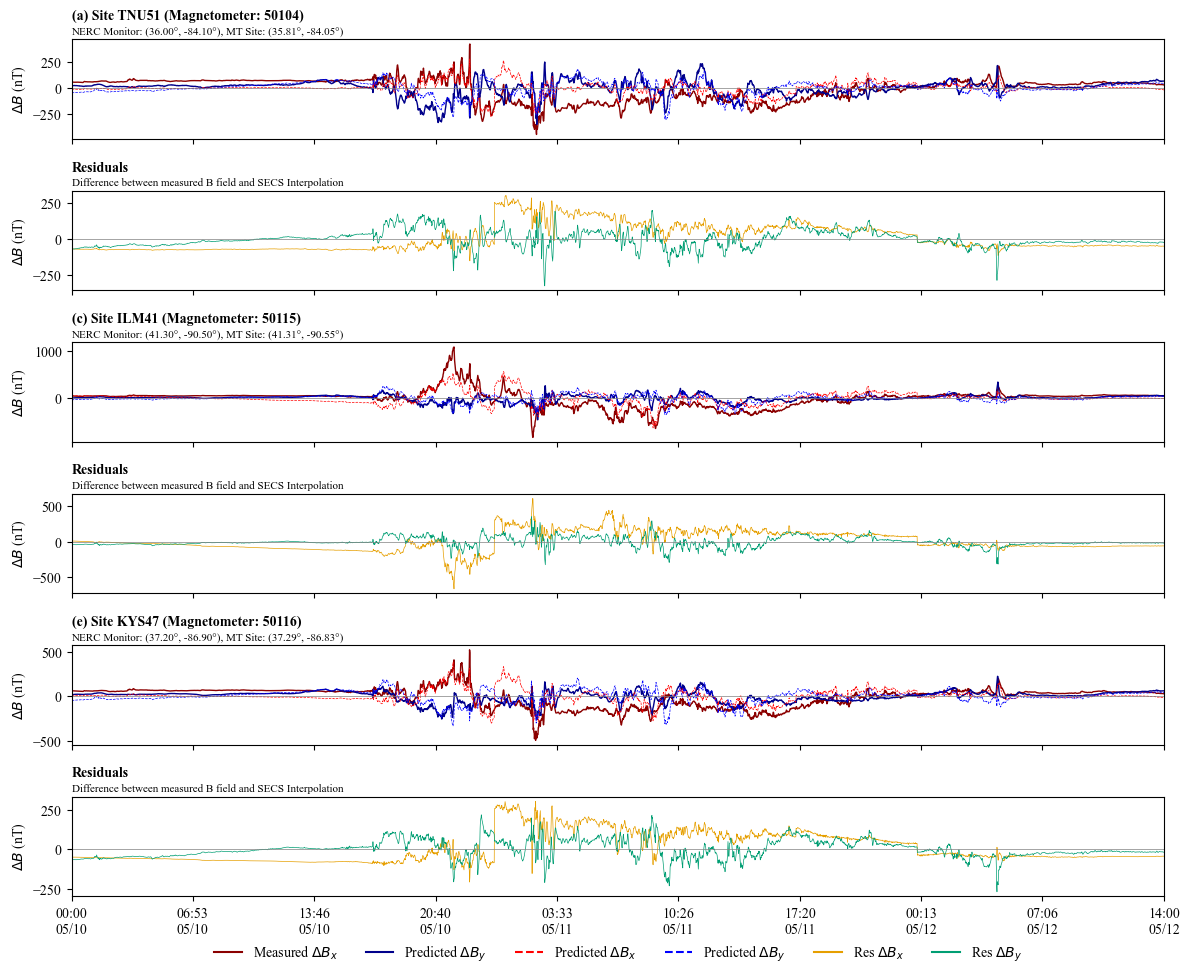

In [367]:
# Create figure with 2 subplots per site (combined B and delta B)
fig, axes = plt.subplots(nrows=2*n_sites, figsize=(12, 10), sharex=True)

magnetic_plots = [r"Measured $\Delta B_x$", r"Predicted $\Delta B_y$", r"Predicted $\Delta B_x$", r"Predicted $\Delta B_y$", r"Res $\Delta B_x$", r"Res $\Delta B_y$"]
colors = ['darkred', 'darkblue', 'red', 'blue', '#E69F00', '#009E73']
line_types = ["-", "-", "--", "--", "-", "-"]

for site_idx, (mag_station, mt_idx) in enumerate(list(zip(mag_stations_with_mt, mt_indices))[:n_sites]):
    ax1 = axes[2 * site_idx]
    ax2 = axes[2 * site_idx + 1]

    mt_idx = int(mt_idx)
    mag_lat = ds_mag.latitude.sel(device=mag_station).values
    mag_lon = ds_mag.longitude.sel(device=mag_station).values
    mt_lat = magnetotelluric_ds.site_x.isel(site_x=mt_idx).values
    mt_lon = magnetotelluric_ds.site_y.isel(site_y=mt_idx).values
    mt_name = mt_names[mt_idx]
    
    try:
        # Get data
        mag_Bx = ds_mag_sliced.B_North.sel(device=mag_station).values
        mag_By = ds_mag_sliced.B_East.sel(device=mag_station).values
        mt_Bx = ds_mt_sliced.B_pred.sel(site=mt_idx, component="Bx").values
        mt_By = ds_mt_sliced.B_pred.sel(site=mt_idx, component="By").values
        
        # Plot B components
        ax1.plot(times, mag_Bx, c='darkred', linewidth=1)
        ax1.plot(times, mag_By, c='darkblue', linewidth=1)
        ax1.plot(times, mt_Bx, c='red', linewidth=0.5, linestyle='--')
        ax1.plot(times, mt_By, c='blue', linewidth=0.5, linestyle='--')
        ax1.set_ylabel(r"$\Delta B$ (nT)")
        ax1.axhline(0.0, c="gray", linewidth=0.5)
        ax1.legend()
        
        # Plot differences
        ax2.plot(times, mt_Bx - mag_Bx, c='#E69F00', linewidth=0.5)
        ax2.plot(times, mt_By - mag_By, c='#009E73', linewidth=0.5)
        ax2.set_ylabel(r"$\Delta B$ (nT)")
        ax2.axhline(0.0, c="gray", linewidth=0.5)

        # title
        ax1.text(0, 1.2, f'({chr(97+2*site_idx)}) Site {mt_names[mt_idx]} (Magnetometer: {mag_station})', 
        transform=ax1.transAxes, fontsize=10, fontweight='bold')
        ax1.text(0, 1.05, f'NERC Monitor: ({mag_lat:.2f}°, {mag_lon:.2f}°), MT Site: ({mt_lat:.2f}°, {mt_lon:.2f}°)', 
        transform=ax1.transAxes, fontsize=8)
        
        # title and subtitle for residuals plot
        ax2.text(0, 1.2, "Residuals", transform=ax2.transAxes, fontsize=10, fontweight='bold')
        ax2.text(0, 1.05, "Difference between measured B field and SECS Interpolation", 
            transform=ax2.transAxes, fontsize=8)

        # Legend
        ax1.legend(
        # loc='center left',
        # bbox_to_anchor=(1.01, 0.5),
        # frameon=False
        ).set_visible(False)
        
        ax2.legend(
           loc='lower left',
           bbox_to_anchor=(0, -0.1),
           frameon=False ).set_visible(False)
        
    except Exception as e:
        print(f"Error plotting site {mag_station}: {e}")
        continue

# Create legend elements once
mag_legend_elements = [Line2D([0], [0], linestyle=line_style, color=colors[i], label=f'{threshold}') 
                         for i, (threshold,line_style) in enumerate(zip(magnetic_plots, line_types))]

axes[-1].legend(
    handles=mag_legend_elements, 
    # title="Thresholds (A/Ph):", 
    loc='lower center', 
    ncol=len(magnetic_plots) + 1,  # +1 to include space for title
    frameon=False, 
    bbox_to_anchor=(0.5, -0.8),
    alignment='left'  # Aligns title to the left
)

# Set x-axis limits and labels (keep existing code)
axes[-1].set_xlim(times[0], times[-1])
# Create 6 evenly spaced tick positions using linspace
tick_positions = np.linspace(0, len(times)-1, 10, dtype=int)
tick_times = [times[i] for i in tick_positions]
axes[-1].set_xticks(tick_times)
axes[-1].set_xticklabels([t.strftime("%H:%M\n%m/%d") for t in tick_times])

plt.tight_layout()
fig.savefig("dennies_figs/magnetic_field_comparisons.png", dpi=300)
plt.show()

In [368]:
# Remove duplicate substations
unique_substations = matches_df.drop_duplicates(subset=["substation"])
dropped_substations = matches_df[~matches_df.index.isin(unique_substations.index)]

# Remove duplicate monitoring sites
unique_sites = unique_substations.drop_duplicates(subset=["monitor_name"])
dropped_sites = unique_substations[~unique_substations.index.isin(unique_sites.index)]

# Get the remaining cleaned dataset
cleaned_df = unique_sites.copy()
cleaned_df = cleaned_df[cleaned_df.monitor_name.isin(site_ids)]

# Save dropped duplicates for reference
dropped_duplicates_df = pd.concat([dropped_substations, dropped_sites])

matching_substations = cleaned_df["substation"].values
matching_sites = cleaned_df["monitor_name"].values

In [369]:
def read_ground_gic_simulations(ground_gic_folder, peak_times_path):
    # Read recursively the ground gic sensitivity dfs
    gnd_files = list(ground_gic_folder.glob("*.csv"))
    
    peak_times = np.load(peak_times_path)
    
    # Load all CSVs into a 3D NumPy array (Simulations, Substations, Time Steps)
    data_list = [pd.read_csv(file).iloc[:, 1:].values for file in gnd_files]  # Exclude 'Substation' column
    data_array = np.stack(data_list, axis=0)  # Shape: (num_simulations, num_substations, num_timesteps)

    mean_values = np.mean(data_array, axis=0)  # Shape: (num_substations, num_timesteps)
    median_values = np.median(data_array, axis=0)
    
    # Uncertainty
    uncertainty_arr = np.percentile(data_array, [2.5, 97.5], axis=0)

    # Sample df
    sample_df = pd.read_csv(gnd_files[0])
    substation_names = sample_df["Substation"].values
    
    return data_array, peak_times, median_values, mean_values, uncertainty_arr, substation_names

def get_nerc_gic_measurements(matching_sites, peak_times):
    
    # Initialize the array to the store the values
    gic_realtime = np.zeros((len(matching_sites), peak_times.shape[0]))
    
    for time_idx, time in enumerate(peak_times):
        gic_peak_values = np.zeros(len(matching_sites))  # Holds GIC values for this timestep
        
        for i, monitor_site in enumerate(matching_sites):
            gic_val = ds.gic.sel(time=time, device=monitor_site).values  # Use correct time variable
            gic_peak_values[i] = gic_val.ravel()[0]  # Ensure single value extraction
        
        gic_realtime[:, time_idx] = gic_peak_values  # Assign to the correct array
    
    return gic_realtime

In [370]:
# Read the info df
info_df = pd.read_csv(data_loc / ".." / "info" / "info.csv")

site_ids = info_df[info_df.error.isna()].site_id.unique()
site_ids = ['10052', '10076', '10099', '10238', '10255', '10587', '10618',
       '10619', '10622', '10063', '10077', '10079', '10107', '10112',
       '10113', '10114', '10115', '10402', '10428', '10438', '10659',
       '10660', '10693', '10181', '10182', '10184', '10185', '10186',
       '10187', '10195', '10197', '10200', '10201', '10203', '10204',
       '10207', '10208', '10212', '10220', '10249', '10250', '50100',
       '50127', '50112', '50131', '50132', '50103', '50104', '50109',
       '50115', '50116', '50117', '50118', '50119', '50120', '50122',]

site_ids = [int(site) for site in site_ids]
#  Read the NERC monitor fidelity data
info_df = pd.read_csv(data_loc / ".." / "info" / "info.csv")

info_df.head(5)

,site_id,geo_lat,geo_lon,data_type,data_class,data_source,error
0,10052,44.9,-97.0,GIC,measured,NERC,NaN
1,10064,41.8,-88.2,GIC,measured,NERC,stays at zero
2,10065,41.8,-87.8,GIC,measured,NERC,"periods of missing data, otherwise fine"
3,10066,41.6,-87.9,GIC,measured,NERC,"not centered on zero, noisy"
4,10067,42.1,-87.9,GIC,measured,NERC,"all negative, not smooth"


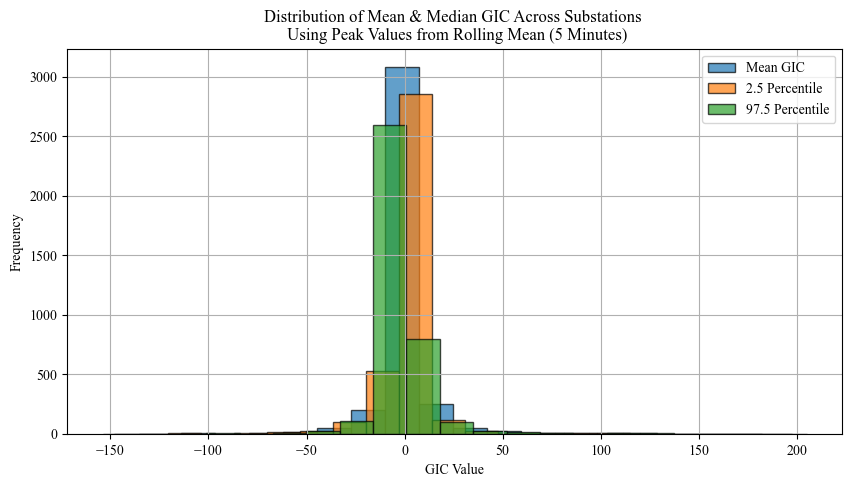

In [371]:
# Read precomputed peak times
peak_times_path = 'peak_times.npy'
ground_gic_folder = data_loc / "ground_gic"

data_array, peak_times, median_values, mean_values, uncertainty_arr, substation_names = read_ground_gic_simulations(ground_gic_folder, peak_times_path)
gic_realtime = get_nerc_gic_measurements(matching_sites, peak_times)

plt.figure(figsize=(10, 5))

# Histogram of mean GIC values
plt.hist(
    mean_values[:, 11], bins=20, alpha=0.7, label="Mean GIC", edgecolor="black"
)

# Histogram of median GIC values
plt.hist(
    uncertainty_arr[0, :, 11],
    bins=20,
    alpha=0.7,
    label="2.5 Percentile",
    edgecolor="black",
)

# Histogram of median GIC values
plt.hist(
    uncertainty_arr[1, :, 11],
    bins=20,
    alpha=0.7,
    label="97.5 Percentile",
    edgecolor="black",
)

plt.xlabel("GIC Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean & Median GIC Across Substations \n Using Peak Values from Rolling Mean (5 Minutes)")
plt.legend()
plt.grid(True)
plt.show()

## Note on Title
Predicted geoelectric field peaks were identified by applying a 5-minute rolling mean (moving average) with a minimum separation of 5 minutes, starting at 05:10:00 UTC. Peak selection was based on the smoothed total field magnitude, using prominence and distance criteria to ensure distinct maxima.

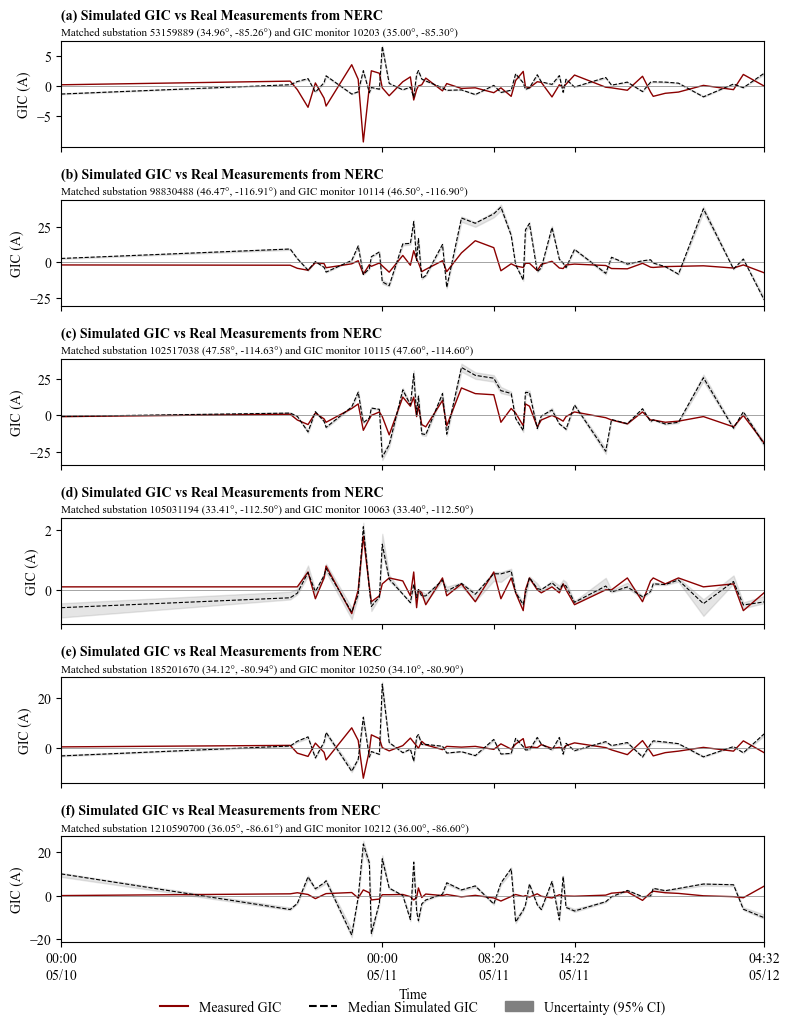

In [372]:
substation_indices = [np.where(substation_names == sub)[0][0] for sub in matching_substations if sub in substation_names]

mean_simulated = median_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]

close_sites = [10203, 10114, 10115, 10063, 10250, 10212] # Sites with almost accurate depiction of GIC
not_close_sites = [10659, 10113, 10402, 10052, 10660, 10185] # sites with almost not accurate depiction of GIC

fig, axes = plt.subplots(nrows=len(close_sites), figsize=(8, 10.5), sharex=True)

# Compute statistics
mean_values = np.mean(data_array, axis=0)  # Shape: (num_substations, num_timesteps)
median_values = np.median(data_array, axis=0)
percentiles = np.percentile(data_array, [2.5, 97.5], axis=0)

# Extract required statistics
mean_simulated = mean_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]
lower_bound = percentiles[0, substation_indices, 1:]
upper_bound = percentiles[1, substation_indices, 1:]

# legend elements
legend_names = ["Measured GIC", "Median Simulated GIC"]
legend_colors =["darkred", "black"]
line_weights = ["-", "--"]

i = 0
for site_idx, site in enumerate(matching_sites):
    if site not in close_sites:
        continue

    mag_station = matching_substations[site_idx]
    sub_lat, sub_lon = matches_df[matches_df.substation == mag_station][['sub_lat', 'sub_lon']].values[0]
    
    mag_lat = ds.latitude.sel(device=site).values
    mag_lon = ds.longitude.sel(device=site).values

    ax = axes[close_sites.index(site)]
    
    # Plot measured and simulated GIC
    ax.plot(peak_times, gic_realtime[site_idx, :], color='darkred', linewidth=1)
    ax.plot(peak_times, median_simulated[site_idx, :], color='black', linestyle='--', linewidth=0.8)
    
    # Shaded uncertainty region
    ax.fill_between(peak_times, lower_bound[site_idx, :], upper_bound[site_idx, :], color='gray', alpha=0.2)
    
    # Formatting
    ax.set_ylabel("GIC (A)")
    ax.axhline(0.0, color="gray", linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False).set_visible(False)
    
    # # Title formatting
    ax.text(0, 1.2, f'({chr(97+i)}) Simulated GIC vs Real Measurements from NERC', 
        transform=ax.transAxes, fontsize=10, fontweight='bold')
    ax.text(0, 1.05, f'Matched substation {mag_station} ({sub_lat:.2f}°, {sub_lon:.2f}°) and GIC monitor {site} ({mag_lat:.2f}°, {mag_lon:.2f}°)', 
        transform=ax.transAxes, fontsize=8)
    i +=1

# Legend elements
patch_legend_element = [mpatches.Patch(color="gray", label=str('Uncertainty (95% CI)'))]

# Create legend elements once
line_legend_elements = [Line2D([0], [0], linestyle=line_weights[i], color=legend_colors[i], label=f'{label}') 
                         for i, label in enumerate(legend_names)]

legend_elements = line_legend_elements + patch_legend_element

axes[-1].legend(
    handles=legend_elements, 
    # title="Thresholds (A/Ph):", 
    loc='lower center', 
    ncol=len(legend_elements) + 1,  # +1 to include space for title
    frameon=False, 
    bbox_to_anchor=(0.5, -0.8),
    alignment='left'  # Aligns title to the left
)

axes[-1].set_xlim(peak_times[0], peak_times[-1])
tick_positions = [peak_times[0], peak_times[len(peak_times)//4], 
                  peak_times[len(peak_times)//2], 
                  peak_times[3*len(peak_times)//4], peak_times[-1]]

axes[-1].set_xticks(tick_positions)
axes[-1].set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions])

# X-axis label
axes[-1].set_xlabel("Time")
plt.tight_layout()

fig.savefig("dennies_figs/gic_comparison_close_peak.png", dpi=300)
plt.show()

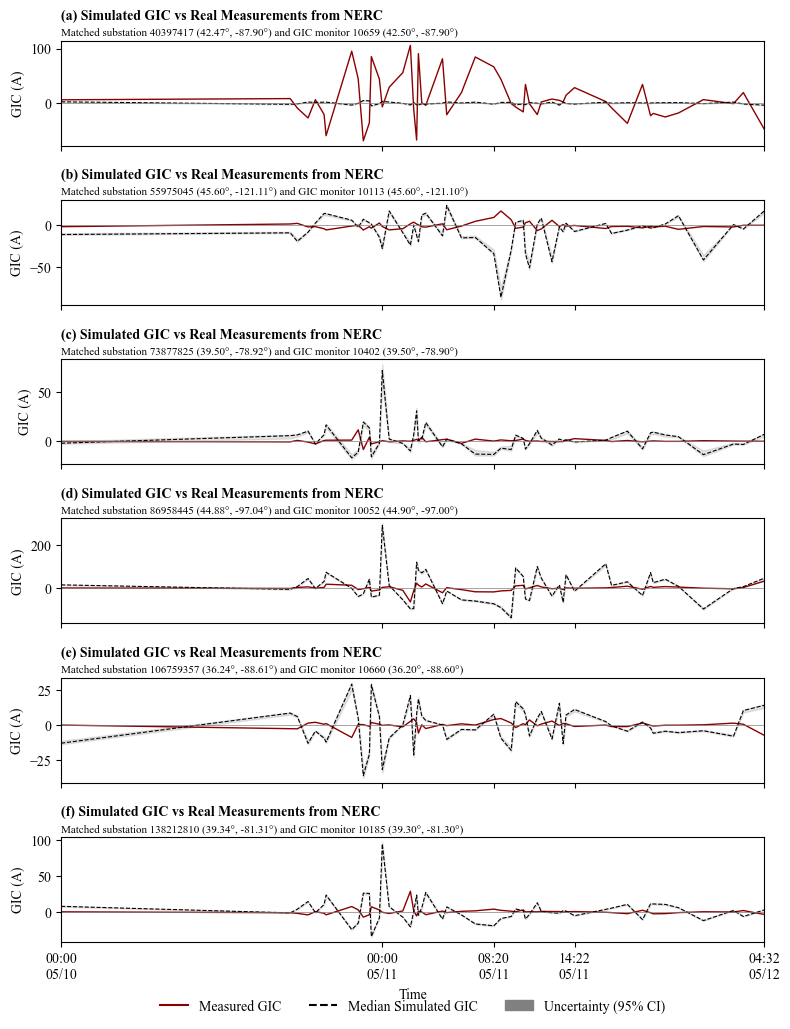

In [373]:
substation_indices = [np.where(substation_names == sub)[0][0] for sub in matching_substations if sub in substation_names]

mean_simulated = median_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]

close_sites = [10203, 10114, 10115, 10063, 10250, 10212] # Sites with almost accurate depiction of GIC
not_close_sites = [10659, 10113, 10402, 10052, 10660, 10185] # sites with almost not accurate depiction of GIC

fig, axes = plt.subplots(nrows=len(close_sites), figsize=(8, 10.5), sharex=True)

# Compute statistics
mean_values = np.mean(data_array, axis=0)  # Shape: (num_substations, num_timesteps)
median_values = np.median(data_array, axis=0)
percentiles = np.percentile(data_array, [2.5, 97.5], axis=0)

# Extract required statistics
mean_simulated = mean_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]
lower_bound = percentiles[0, substation_indices, 1:]
upper_bound = percentiles[1, substation_indices, 1:]

# legend elements
legend_names = ["Measured GIC", "Median Simulated GIC"]
legend_colors =["darkred", "black"]
line_weights = ["-", "--"]

i = 0
for site_idx, site in enumerate(matching_sites):
    if site not in not_close_sites:
        continue

    mag_station = matching_substations[site_idx]
    sub_lat, sub_lon = matches_df[matches_df.substation == mag_station][['sub_lat', 'sub_lon']].values[0]
    
    mag_lat = ds.latitude.sel(device=site).values
    mag_lon = ds.longitude.sel(device=site).values

    ax = axes[not_close_sites.index(site)]
    
    # Plot measured and simulated GIC
    ax.plot(peak_times, gic_realtime[site_idx, :], color='darkred', linewidth=1)
    ax.plot(peak_times, median_simulated[site_idx, :], color='black', linestyle='--', linewidth=0.8)
    
    # Shaded uncertainty region
    ax.fill_between(peak_times, lower_bound[site_idx, :], upper_bound[site_idx, :], color='gray', alpha=0.2)
    
    # Formatting
    ax.set_ylabel("GIC (A)")
    ax.axhline(0.0, color="gray", linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False).set_visible(False)
    
    # # Title formatting
    ax.text(0, 1.2, f'({chr(97+i)}) Simulated GIC vs Real Measurements from NERC', 
        transform=ax.transAxes, fontsize=10, fontweight='bold')
    ax.text(0, 1.05, f'Matched substation {mag_station} ({sub_lat:.2f}°, {sub_lon:.2f}°) and GIC monitor {site} ({mag_lat:.2f}°, {mag_lon:.2f}°)', 
        transform=ax.transAxes, fontsize=8)
    i +=1

# Legend elements
patch_legend_element = [mpatches.Patch(color="gray", label=str('Uncertainty (95% CI)'))]

# Create legend elements once
line_legend_elements = [Line2D([0], [0], linestyle=line_weights[i], color=legend_colors[i], label=f'{label}') 
                         for i, label in enumerate(legend_names)]

legend_elements = line_legend_elements + patch_legend_element

axes[-1].legend(
    handles=legend_elements, 
    # title="Thresholds (A/Ph):", 
    loc='lower center', 
    ncol=len(legend_elements) + 1,  # +1 to include space for title
    frameon=False, 
    bbox_to_anchor=(0.5, -0.8),
    alignment='left'  # Aligns title to the left
)

axes[-1].set_xlim(peak_times[0], peak_times[-1])
tick_positions = [peak_times[0], peak_times[len(peak_times)//4], 
                  peak_times[len(peak_times)//2], 
                  peak_times[3*len(peak_times)//4], peak_times[-1]]

axes[-1].set_xticks(tick_positions)
axes[-1].set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions])

# X-axis label
axes[-1].set_xlabel("Time")
plt.tight_layout()

fig.savefig("dennies_figs/gic_comparison_not_close_peak.png", dpi=300)
plt.show()

## GIC of the measured values after 30 minutes interval

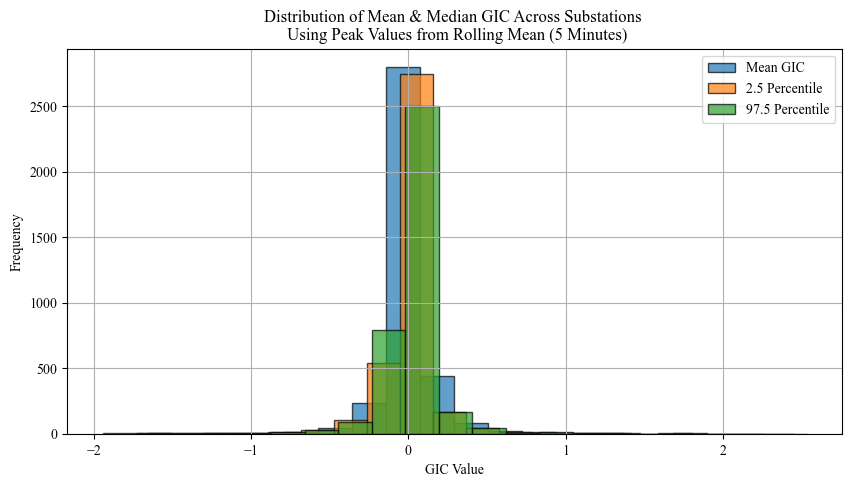

In [374]:
peak_times_path = 'peak_times_1.npy'
ground_gic_folder = data_loc / "ground_gic_gannon"

data_array, peak_times, median_values, mean_values, uncertainty_arr, substation_names = read_ground_gic_simulations(ground_gic_folder, peak_times_path)
gic_realtime = get_nerc_gic_measurements(matching_sites, peak_times)

plt.figure(figsize=(10, 5))

# Histogram of mean GIC values
plt.hist(
    mean_values[:, 11], bins=20, alpha=0.7, label="Mean GIC", edgecolor="black"
)

# Histogram of median GIC values
plt.hist(
    uncertainty_arr[0, :, 11],
    bins=20,
    alpha=0.7,
    label="2.5 Percentile",
    edgecolor="black",
)

# Histogram of median GIC values
plt.hist(
    uncertainty_arr[1, :, 11],
    bins=20,
    alpha=0.7,
    label="97.5 Percentile",
    edgecolor="black",
)

plt.xlabel("GIC Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean & Median GIC Across Substations \n Using Peak Values from Rolling Mean (5 Minutes)")
plt.legend()
plt.grid(True)
plt.show()

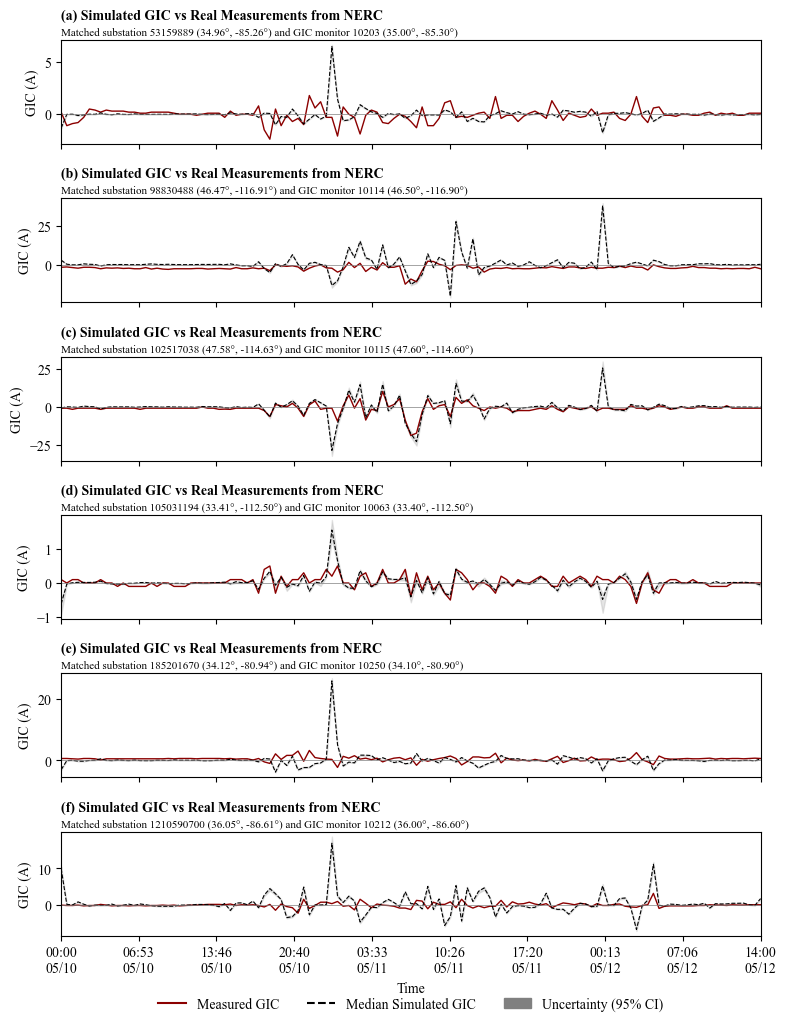

In [375]:
substation_indices = [np.where(substation_names == sub)[0][0] for sub in matching_substations if sub in substation_names]

mean_simulated = median_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]

close_sites = [10203, 10114, 10115, 10063, 10250, 10212] # Sites with almost accurate depiction of GIC
not_close_sites = [10659, 10113, 10402, 10052, 10660, 10185] # sites with almost not accurate depiction of GIC

fig, axes = plt.subplots(nrows=len(close_sites), figsize=(8, 10.5), sharex=True)

# Compute statistics
mean_values = np.mean(data_array, axis=0)  # Shape: (num_substations, num_timesteps)
median_values = np.median(data_array, axis=0)
percentiles = np.percentile(data_array, [2.5, 97.5], axis=0)

# Extract required statistics
mean_simulated = mean_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]
lower_bound = percentiles[0, substation_indices, 1:]
upper_bound = percentiles[1, substation_indices, 1:]

# legend elements
legend_names = ["Measured GIC", "Median Simulated GIC"]
legend_colors =["darkred", "black"]
line_weights = ["-", "--"]

i = 0
for site_idx, site in enumerate(matching_sites):
    if site not in close_sites:
        continue

    mag_station = matching_substations[site_idx]
    sub_lat, sub_lon = matches_df[matches_df.substation == mag_station][['sub_lat', 'sub_lon']].values[0]
    
    mag_lat = ds.latitude.sel(device=site).values
    mag_lon = ds.longitude.sel(device=site).values

    ax = axes[close_sites.index(site)]
    
    # Plot measured and simulated GIC
    ax.plot(peak_times, gic_realtime[site_idx, :], color='darkred', linewidth=1)
    ax.plot(peak_times, median_simulated[site_idx, :], color='black', linestyle='--', linewidth=0.8)
    
    # Shaded uncertainty region
    ax.fill_between(peak_times, lower_bound[site_idx, :], upper_bound[site_idx, :], color='gray', alpha=0.2)
    
    # Formatting
    ax.set_ylabel("GIC (A)")
    ax.axhline(0.0, color="gray", linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False).set_visible(False)
    
    # # Title formatting
    ax.text(0, 1.2, f'({chr(97+i)}) Simulated GIC vs Real Measurements from NERC', 
        transform=ax.transAxes, fontsize=10, fontweight='bold')
    ax.text(0, 1.05, f'Matched substation {mag_station} ({sub_lat:.2f}°, {sub_lon:.2f}°) and GIC monitor {site} ({mag_lat:.2f}°, {mag_lon:.2f}°)', 
        transform=ax.transAxes, fontsize=8)
    i +=1

# Legend elements
patch_legend_element = [mpatches.Patch(color="gray", label=str('Uncertainty (95% CI)'))]

# Create legend elements once
line_legend_elements = [Line2D([0], [0], linestyle=line_weights[i], color=legend_colors[i], label=f'{label}') 
                         for i, label in enumerate(legend_names)]

legend_elements = line_legend_elements + patch_legend_element

axes[-1].legend(
    handles=legend_elements, 
    # title="Thresholds (A/Ph):", 
    loc='lower center', 
    ncol=len(legend_elements) + 1,  # +1 to include space for title
    frameon=False, 
    bbox_to_anchor=(0.5, -0.85),
    alignment='left'  # Aligns title to the left
)

axes[-1].set_xlim(times[0], times[-1])
# Create 6 evenly spaced tick positions using linspace
tick_positions = np.linspace(0, len(times)-1, 10, dtype=int)
tick_times = [times[i] for i in tick_positions]
axes[-1].set_xticks(tick_times)
axes[-1].set_xticklabels([t.strftime("%H:%M\n%m/%d") for t in tick_times])

# X-axis label
axes[-1].set_xlabel("Time")
plt.tight_layout()

fig.savefig("dennies_figs/gic_comparison_close_30_mins.png", dpi=300)
plt.show()

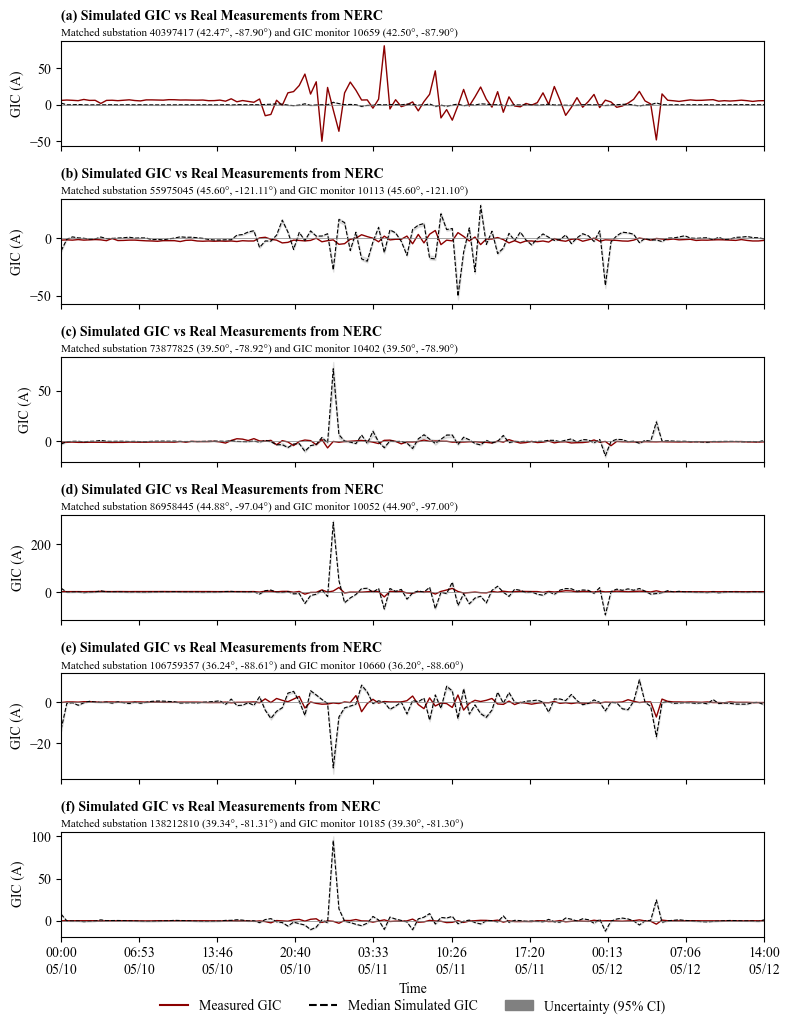

In [376]:
substation_indices = [np.where(substation_names == sub)[0][0] for sub in matching_substations if sub in substation_names]

mean_simulated = median_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]

close_sites = [10203, 10114, 10115, 10063, 10250, 10212] # Sites with almost accurate depiction of GIC
not_close_sites = [10659, 10113, 10402, 10052, 10660, 10185] # sites with almost not accurate depiction of GIC

fig, axes = plt.subplots(nrows=len(close_sites), figsize=(8, 10.5), sharex=True)

# Compute statistics
mean_values = np.mean(data_array, axis=0)  # Shape: (num_substations, num_timesteps)
median_values = np.median(data_array, axis=0)
percentiles = np.percentile(data_array, [2.5, 97.5], axis=0)

# Extract required statistics
mean_simulated = mean_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]
lower_bound = percentiles[0, substation_indices, 1:]
upper_bound = percentiles[1, substation_indices, 1:]

# legend elements
legend_names = ["Measured GIC", "Median Simulated GIC"]
legend_colors =["darkred", "black"]
line_weights = ["-", "--"]

i = 0
for site_idx, site in enumerate(matching_sites):
    if site not in not_close_sites:
        continue

    mag_station = matching_substations[site_idx]
    sub_lat, sub_lon = matches_df[matches_df.substation == mag_station][['sub_lat', 'sub_lon']].values[0]
    
    mag_lat = ds.latitude.sel(device=site).values
    mag_lon = ds.longitude.sel(device=site).values

    ax = axes[not_close_sites.index(site)]
    
    # Plot measured and simulated GIC
    ax.plot(peak_times, gic_realtime[site_idx, :], color='darkred', linewidth=1)
    ax.plot(peak_times, median_simulated[site_idx, :], color='black', linestyle='--', linewidth=0.8)
    
    # Shaded uncertainty region
    ax.fill_between(peak_times, lower_bound[site_idx, :], upper_bound[site_idx, :], color='gray', alpha=0.2)
    
    # Formatting
    ax.set_ylabel("GIC (A)")
    ax.axhline(0.0, color="gray", linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False).set_visible(False)
    
    # # Title formatting
    ax.text(0, 1.2, f'({chr(97+i)}) Simulated GIC vs Real Measurements from NERC', 
        transform=ax.transAxes, fontsize=10, fontweight='bold')
    ax.text(0, 1.05, f'Matched substation {mag_station} ({sub_lat:.2f}°, {sub_lon:.2f}°) and GIC monitor {site} ({mag_lat:.2f}°, {mag_lon:.2f}°)', 
        transform=ax.transAxes, fontsize=8)
    i +=1

# Legend elements
patch_legend_element = [mpatches.Patch(color="gray", label=str('Uncertainty (95% CI)'))]

# Create legend elements once
line_legend_elements = [Line2D([0], [0], linestyle=line_weights[i], color=legend_colors[i], label=f'{label}') 
                         for i, label in enumerate(legend_names)]

legend_elements = line_legend_elements + patch_legend_element

axes[-1].legend(
    handles=legend_elements, 
    # title="Thresholds (A/Ph):", 
    loc='lower center', 
    ncol=len(legend_elements) + 1,  # +1 to include space for title
    frameon=False, 
    bbox_to_anchor=(0.5, -0.85),
    alignment='left'  # Aligns title to the left
)

axes[-1].set_xlim(times[0], times[-1])
# Create 6 evenly spaced tick positions using linspace
tick_positions = np.linspace(0, len(times)-1, 10, dtype=int)
tick_times = [times[i] for i in tick_positions]
axes[-1].set_xticks(tick_times)
axes[-1].set_xticklabels([t.strftime("%H:%M\n%m/%d") for t in tick_times])

# X-axis label
axes[-1].set_xlabel("Time")
plt.tight_layout()

fig.savefig("dennies_figs/gic_comparison_not_close_30_mins.png", dpi=300)
plt.show()